# Deep Residual Net

### CIFAR-100 데이터 받기

In [1]:
import os
import sys
import tensorflow as tf
import keras
from six.moves import urllib
import gzip
import pickle
import numpy as np

# from tf.keras.utils import get_file

%matplotlib inline
import matplotlib.pyplot as plt
from keras.utils.data_utils import get_file
from keras.datasets.cifar import load_batch
from keras import backend as K

def load_data(label_mode='fine'):
    if label_mode not in ['fine', 'coarse']:
        raise ValueError('`label_mode` must be one of `"fine"`, `"coarse"`.')

    dirname = 'cifar-100-python'
    origin = 'https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz'
    path = get_file(dirname, origin=origin, untar=True)

    fpath = os.path.join(path, 'train')
    x_train, y_train = load_batch(fpath, label_key=label_mode + '_labels')

    fpath = os.path.join(path, 'test')
    x_test, y_test = load_batch(fpath, label_key=label_mode + '_labels')

    y_train = np.reshape(y_train, (len(y_train), 1))
    y_test = np.reshape(y_test, (len(y_test), 1))

    if K.image_data_format() == 'channels_last':
        x_train = x_train.transpose(0, 2, 3, 1)
        x_test = x_test.transpose(0, 2, 3, 1)

    return (x_train, y_train), (x_test, y_test)
(train_data,train_label),(test_data,test_label) = load_data()
train_data = train_data / 255.0
test_data = test_data / 255.0

Using TensorFlow backend.


### Shape 확인

In [2]:
# size of cifar-100
print(train_data.shape)
print(train_label.shape)
print(test_data.shape)
print(test_label.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


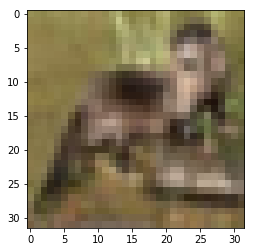

In [3]:
# show data
_, (ax1) = plt.subplots(1)
sample_data = train_data[100]
ax1.imshow(sample_data, cmap=plt.cm.Greys);

### residual block

In [4]:
def residual_block(X_input, num_filter, chg_dim) :
    stride = 1
        
    #stride=2일 경우
    if chg_dim :
        stride = 2
        pool1 = tf.layers.max_pooling2d(inputs= X_input, strides=2, pool_size=[2,2])
        pad1 = tf.pad(pool1, [[0,0], [0,0], [0,0], [int(num_filter/4),int(num_filter/4)]])
        shortcut = pad1
    else :
        shortcut = X_input
        
    bm1 = tf.layers.batch_normalization(inputs = X_input)
    relu1 = tf.nn.relu(bm1)
    conv1 = tf.layers.conv2d(inputs = relu1, filters=num_filter, kernel_size=[3, 3], padding="SAME", strides=stride, kernel_initializer=tf.contrib.layers.xavier_initializer())

    bm2 = tf.layers.batch_normalization(inputs = conv1)
    relu2 = tf.nn.relu(bm2)
    conv2 = tf.layers.conv2d(inputs = relu2, filters=num_filter, kernel_size=[3, 3], padding="SAME", strides=1, kernel_initializer=tf.contrib.layers.xavier_initializer())
        
    X_output = conv2 + shortcut
        
    return X_output

### building model

In [5]:
def model(x,by) :
    
    with tf.variable_scope('first'):
        outs = tf.layers.conv2d(inputs = x, filters = 64, kernel_size=[7,7], padding="SAME", strides=2)
        outs = tf.layers.batch_normalization(inputs = outs)
        outs = tf.nn.relu(outs)
    
#     #pooling    
    outs = tf.layers.max_pooling2d(inputs = outs, strides = 2, pool_size=2)
    
    
    outs = residual_block(outs, 64, False)
    outs = residual_block(outs, 64, False)
    outs = residual_block(outs, 64, False)

    outs = residual_block(outs, 128, True)
    outs = residual_block(outs, 128, False)
    outs = residual_block(outs, 128, False)
    outs = residual_block(outs, 128, False)

    outs = residual_block(outs, 256, True)
    outs = residual_block(outs, 256, False)
    outs = residual_block(outs, 256, False)
    outs = residual_block(outs, 256, False)
    outs = residual_block(outs, 256, False)
    outs = residual_block(outs, 256, False)
                                   
    outs = residual_block(outs, 512, True)
    outs = residual_block(outs, 512, False)
    outs = residual_block(outs, 512, False)

    #Average Pooling
    outs = tf.reduce_mean(outs, [1, 2], keep_dims=True)

    outs = tf.reshape(outs, (-1, outs.shape[1]*outs.shape[2]*outs.shape[3]))
    outs = tf.layers.dense(outs, 100)
                                   
    #one_hot
    one_hot = tf.squeeze(tf.one_hot(by, 100),axis=1)

    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=outs, labels=one_hot))
    opt = tf.train.AdamOptimizer(learning_rate=0.0005).minimize(loss)
    preds = tf.equal(tf.argmax(outs, 1), tf.argmax(one_hot, 1))     
    acc = tf.reduce_mean(tf.cast(preds, tf.float32))
    init = tf.global_variables_initializer()
                                   
    return {
        'loss':loss,
        'opt':opt,
        'preds':preds,
        'acc':acc,
        'init':init
    }

In [6]:
X = tf.placeholder(tf.float32, shape=(None, 32, 32, 3))
by = tf.placeholder(tf.int32)

renset = model(X, by)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



### Training_Testing

In [7]:
num_epochs = 100
batch_size = 100
num_display = 100

with tf.Session() as sess:
    sess.run(renset['init'])
    for ind_epoch in range(0, num_epochs):
        print('Current iteration {}'.format(ind_epoch + 1))

        for ind_ in range(0, int(50000 / batch_size)):
            batch_X = train_data[ind_*batch_size:(ind_+1)*batch_size]
            batch_by = train_label[ind_*batch_size:(ind_+1)*batch_size]
            _, cur_loss, cur_acc = sess.run(
                [renset['opt'], renset['loss'], renset['acc']],
                feed_dict={X: batch_X, by: batch_by})
            if ind_ % num_display == 0:
                print('loss {0:.4f} acc {1:.4f}'.format(cur_loss, cur_acc))
    cur_acc_all = 0.0
    cur_loss_all = 0.0
    for ind_ in range(0, 10):
        cur_loss, cur_acc = sess.run(
                    [renset['loss'], renset['acc']],
                    feed_dict={X: test_data[ind_*1000:(ind_+1)*1000], 
                               by: test_label[ind_*1000:(ind_+1)*1000]})
        cur_loss_all += cur_loss
        cur_acc_all += cur_acc
    print('TEST: loss {0:.4f} acc {1:.4f}'.format(cur_loss_all / 10.0, 
                                                  cur_acc_all / 10.0))

Current iteration 1
loss 4.7189 acc 0.0200
loss 4.2036 acc 0.0600
loss 3.9932 acc 0.0600
loss 3.8268 acc 0.1600
loss 3.5803 acc 0.1700
Current iteration 2
loss 3.3569 acc 0.2300
loss 3.2013 acc 0.1900
loss 3.0689 acc 0.2500
loss 3.1594 acc 0.2400
loss 3.0594 acc 0.2500
Current iteration 3
loss 2.9155 acc 0.3100
loss 2.7386 acc 0.2500
loss 2.4752 acc 0.3800
loss 2.6805 acc 0.3100
loss 2.7920 acc 0.2600
Current iteration 4
loss 2.5713 acc 0.3200
loss 2.3051 acc 0.3500
loss 2.1145 acc 0.4000
loss 2.3277 acc 0.3800
loss 2.3418 acc 0.3300
Current iteration 5
loss 2.1869 acc 0.4000
loss 2.0423 acc 0.4600
loss 1.6938 acc 0.5300
loss 1.9872 acc 0.4900
loss 1.9415 acc 0.4700
Current iteration 6
loss 1.8125 acc 0.5200
loss 1.7999 acc 0.4700
loss 1.3708 acc 0.6300
loss 1.4912 acc 0.6100
loss 1.6806 acc 0.5000
Current iteration 7
loss 1.2912 acc 0.6400
loss 1.2784 acc 0.6200
loss 1.1696 acc 0.6800
loss 1.4182 acc 0.6300
loss 1.3492 acc 0.6200
Current iteration 8
loss 0.9878 acc 0.6500
loss 0.9748 

loss 0.0103 acc 1.0000
loss 0.0554 acc 0.9800
loss 0.1263 acc 0.9800
loss 0.1193 acc 0.9800
Current iteration 62
loss 0.0201 acc 0.9900
loss 0.1086 acc 0.9700
loss 0.0291 acc 0.9900
loss 0.0300 acc 0.9900
loss 0.1515 acc 0.9500
Current iteration 63
loss 0.0777 acc 0.9800
loss 0.0221 acc 0.9900
loss 0.1458 acc 0.9700
loss 0.0796 acc 0.9800
loss 0.0702 acc 0.9900
Current iteration 64
loss 0.0268 acc 1.0000
loss 0.0410 acc 0.9800
loss 0.0421 acc 0.9900
loss 0.0386 acc 0.9900
loss 0.0613 acc 0.9900
Current iteration 65
loss 0.0606 acc 0.9800
loss 0.0806 acc 0.9700
loss 0.0120 acc 1.0000
loss 0.1127 acc 0.9800
loss 0.0916 acc 0.9800
Current iteration 66
loss 0.0296 acc 0.9900
loss 0.1834 acc 0.9600
loss 0.0264 acc 0.9800
loss 0.0965 acc 0.9700
loss 0.0246 acc 0.9900
Current iteration 67
loss 0.1695 acc 0.9600
loss 0.0165 acc 1.0000
loss 0.0198 acc 0.9900
loss 0.0106 acc 1.0000
loss 0.0196 acc 1.0000
Current iteration 68
loss 0.1057 acc 0.9700
loss 0.1381 acc 0.9600
loss 0.0262 acc 0.9900
lo